In [219]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [220]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import scipy
import json
import sys
path = ''
sys.path.append(path)
import utils
import settings
import pickle
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [221]:
def save(nom,model):
  # Enregistrez le modele (ML/scaler/autre) dans un fichier
  with open(nom+'.pkl', 'wb') as f:
      pickle.dump(model, f)

In [222]:
def f_open(chemin):
  with open(chemin, 'rb') as f:
    modele = pickle.load(f)
  return modele

# Hyper params

In [223]:
train_delta_t = 0
max_depth = 4
eval_metric = 'rmse'
n_estimators = 10000
scaler_name = 'Normalizer'
scaler_a = Normalizer()
scaler_b = Normalizer()
scaler_c = Normalizer()
random_state = 37
submission_path = 'random_set_sub/'

In [224]:
path = path
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = utils.read_files(diff_path=path)
test = pd.read_csv(path+"test.csv")
sample_submission = pd.read_csv(path+"sample_submission.csv")

# B and C clean up

In [225]:
def filter_dates_when_constants(df, date_c = 'time', y = 'pv_measurement', delta = { 'days': 3 }):
    df = df.copy()
    mask_y_change = df[y] != df[y].shift(1)

    start_date = None
    end_date = None

    constant_periods = []

    for index, row in df.iterrows():
        if not mask_y_change[index]:
            if start_date is None:
                start_date = row[date_c]
            end_date = row[date_c]
        else:
            if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
                constant_periods.append((start_date, end_date))
            start_date = None
            end_date = None

    if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
        constant_periods.append((start_date, end_date))
    return constant_periods

In [226]:
def delete_date_range_from_df(df, dates, date_c = 'time'):
    df = df.copy()
    c = 0
    for start_date, end_date in dates:
        mask = (df[date_c] >= start_date) & (df[date_c] < end_date)
        df = df[~mask]
    df.reset_index(drop=True, inplace=True)
    return df

In [227]:
delta = { 'hours': 12 * 5}
train_a = delete_date_range_from_df(train_a, filter_dates_when_constants(train_a, delta=delta))
train_b = delete_date_range_from_df(train_b, filter_dates_when_constants(train_b, delta=delta))
train_c = delete_date_range_from_df(train_c, filter_dates_when_constants(train_c, delta=delta))

In [228]:
delta_title = str(train_delta_t)
delta_h = pd.Timedelta(minutes=train_delta_t)
train_a['date_forecast'] = train_a['time'] - delta_h
train_b['date_forecast'] = train_b['time'] - delta_h
train_c['date_forecast'] = train_c['time'] - delta_h

# Réorganisation des df :

In [229]:
# observed + estimated
X_total_a = pd.concat([X_train_observed_a,X_train_estimated_a])
X_total_b = pd.concat([X_train_observed_b,X_train_estimated_b])
X_total_c = pd.concat([X_train_observed_c,X_train_estimated_c])

Attention, il faut penser à revoir les valeurs météo et pv de estimated !!!

# Changement nom time dans les train

In [230]:
# train_a.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# train_b.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# train_c.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# test.rename(columns={'time': 'date_forecast'}, inplace=True)
train_a, train_b, train_c = train_a.drop(columns='time'), train_b.drop(columns='time'), train_c.drop(columns='time')
train_a.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_b.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_c.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides

# Correspondance X et y :

Ici nous avons plusieurs choix :    
- matcher directement sur dateforcast
- matcher sur dateforcast et résumer nos variables météo en moyenne et écart type
- matcher sur un autre créneau (peut être fais sur des variables spécifique !)

Dans un premier temps on fera directement sur dateforcast

In [231]:
X_total_a_y = pd.merge(X_total_a, train_a, on='date_forecast', how='inner')
X_total_b_y = pd.merge(X_total_b, train_b, on='date_forecast', how='inner')
X_total_c_y = pd.merge(X_total_c, train_c, on='date_forecast', how='inner')

In [232]:
def gestion_nan(df):
  df_copy = df.copy()
  #delete of the snow density column
  df_copy = df_copy.drop('snow_density:kgm3',axis=1)
  # Approximation of the other two columns
  df_copy['ceiling_height_agl:m'] = df_copy['ceiling_height_agl:m'].interpolate(method='linear', limit_direction='both')
  df_copy['cloud_base_agl:m'] = df_copy['cloud_base_agl:m'].interpolate(method='linear', limit_direction='both')
  return df_copy

In [233]:
X_train_observed_a_nan = gestion_nan(X_train_observed_a)

# Traitement des df + séparation train/test

## Séparation train/test

A la fin on va projeter à partir de donnée météo estimer sur un periode non rencontré.

On va donc séparer notre train/test sur les même conditions, à savoir que le test sera issue de estimated. Il ne reste qu'à fixer la date à partir de laquelle on fait la séparation.

L'objectif est aussi d'avoir de l'estimated dans l'entrainement pour prendre en compte la différence entre observed et estimated qui devra être régler plus tard.

In [234]:
print(len(X_train_observed_a))
print(len(X_train_estimated_a))
print(len(X_train_estimated_a)/(len(X_train_estimated_a)+len(X_train_observed_a)))

118669
17576
0.12900289918896107


In [235]:
X_total_a_y_nan = gestion_nan(X_total_a_y)
X_total_b_y_nan = gestion_nan(X_total_b_y)
X_total_c_y_nan = gestion_nan(X_total_c_y)

In [236]:
split_date_a = X_train_estimated_a['date_forecast'].quantile(0.25)
split_date_b = X_train_estimated_b['date_forecast'].quantile(0.25)
split_date_c = X_train_estimated_c['date_forecast'].quantile(0.25)

In [237]:
split_date_a = pd.to_datetime("2021-04-15")
split_date2_a = pd.to_datetime("2021-08-15")

split_date_b = pd.to_datetime("2019-04-15")
split_date2_b = pd.to_datetime("2019-08-15")

split_date_c = pd.to_datetime("2021-04-15")
split_date2_c = pd.to_datetime("2021-08-15")

In [238]:
start_2019 = pd.to_datetime("2019-03-21")
end_2019 = pd.to_datetime("2019-09-22")

start_2020 = pd.to_datetime("2020-03-21")
end_2020 = pd.to_datetime("2020-09-22")

start_2021 = pd.to_datetime("2021-03-21")
end_2021 = pd.to_datetime("2021-09-22")

start_2022 = pd.to_datetime("2022-03-21")
end_2022 = pd.to_datetime("2022-09-22")

In [239]:
def create_mask_for_split_training_and_testing(df, start_estimated, time_column = 'date_forecast'):
    mask_2019 = ((df[time_column] >= start_2019) & (df[time_column] < end_2019))
    mask_2020 = ((df[time_column] >= start_2020) & (df[time_column] < end_2020))
    mask_2021 = ((df[time_column] >= start_2021) & (df[time_column] < end_2021))
    mask_2022 = ((df[time_column] >= start_2022) & (df[time_column] < end_2022))
    mask_estimated = (df[time_column] >= start_estimated)
    return mask_2019, mask_2020, mask_2021, mask_2022,mask_estimated

In [240]:
def split_training_testing_set(df, start_estimated, random_state=42, text_size = .1):
    df_to_split = df.copy()
    mask_2019, mask_2020, mask_2021, mask_2022, mask_estimated = create_mask_for_split_training_and_testing(df_to_split, start_estimated)
    df_summers = df_to_split[mask_2019 | mask_2020 | mask_2021 | mask_2022 | mask_estimated]
    df_not_summer = df_to_split[~(mask_2019 | mask_2020 | mask_2021 | mask_2022 | mask_estimated)]
    test_size = text_size * (len(df_summers) + len(df_not_summer)) / len(df_summers)
    train_data_summer, pv_test_not_ordered = train_test_split(df_summers, test_size=test_size, random_state=random_state)

    pv_train_not_ordered = pd.concat([train_data_summer, df_not_summer])
    pv_train = pv_train_not_ordered.sort_values(by='date_forecast')
    pv_test = pv_test_not_ordered.sort_values(by='date_forecast')
    return pv_train, pv_test

In [241]:
pv_train_a, pv_test_a = split_training_testing_set(X_total_a_y_nan, X_train_estimated_a["date_forecast"].mean(), random_state=random_state)
pv_train_b, pv_test_b = split_training_testing_set(X_total_b_y_nan, X_train_estimated_b["date_forecast"].mean(), random_state=random_state)
pv_train_c, pv_test_c = split_training_testing_set(X_total_c_y_nan, X_train_estimated_c["date_forecast"].mean(), random_state=random_state)

In [242]:
pv_test_a

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,date_calc,pv_measurement
3,2019-06-03 01:00:00,8.2,1.218,1388.400024,0.000000e+00,0.000000,1388.400024,0.0,281.299988,0.000000,0.000000,0.000000,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1004.400024,0.00,0.0,991.799988,997.799988,0.0,0.2,71.099998,1003.799988,0.0,0.0,-0.0,0.7,23.541000,-1.986000,0.0,286.899994,100.000000,2104.600098,2.8,-2.7,0.8,-0.0,NaT,0.00
8,2019-06-03 06:00:00,9.7,1.204,672.799988,1.180469e+06,393.799988,672.799988,0.0,283.799988,159.199997,503999.687500,43.400002,180710.906250,94.599998,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1000.599976,0.00,0.0,988.200012,994.099976,0.0,0.0,76.199997,1000.000000,0.0,0.0,-0.0,0.0,89.064003,24.580000,0.0,287.600006,98.300003,38816.898438,2.1,-1.9,0.9,-0.0,NaT,904.42
9,2019-06-03 07:00:00,9.3,1.206,665.000000,1.651958e+06,522.599976,665.000000,0.0,283.299988,197.699997,642383.375000,23.000000,119572.398438,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1001.000000,0.00,0.0,988.500000,994.400024,0.0,0.1,73.300003,1000.400024,0.0,0.0,-0.0,0.3,102.903000,31.254000,0.0,287.200012,100.000000,3073.600098,2.8,-1.3,2.5,-0.0,NaT,1238.82
11,2019-06-03 09:00:00,10.1,1.201,649.200012,2.471160e+06,730.500000,649.200012,0.0,284.500000,242.100006,834273.500000,30.299999,76766.000000,99.699997,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1000.599976,0.00,0.0,988.000000,993.799988,0.0,0.1,77.800003,999.799988,0.0,0.0,-0.0,0.3,134.822998,42.949001,0.0,287.700012,100.000000,3585.300049,2.4,-0.7,2.3,-0.0,NaT,3047.22
12,2019-06-03 10:00:00,10.0,1.194,1582.699951,2.752325e+06,793.099976,1582.699951,0.0,284.500000,277.100006,934553.500000,178.800003,376385.093750,79.199997,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1000.099976,0.00,0.0,987.500000,993.299988,0.0,0.1,72.500000,999.200012,0.0,0.0,-0.0,0.0,153.731003,46.875000,0.0,288.700012,94.099998,9568.900391,2.0,-1.0,1.7,-0.0,NaT,2163.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34005,2023-04-29 08:00:00,4.4,1.274,631.099976,1.636698e+06,513.200012,275.200012,0.0,271.899994,101.199997,321381.187500,2.400000,4316.100098,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1008.099976,0.07,3.0,995.000000,1001.299988,0.0,0.0,87.000000,1007.500000,0.0,0.0,-0.0,0.3,122.000000,30.344999,0.2,273.899994,100.000000,3575.899902,0.8,0.8,-0.0,0.0,2023-04-28 07:00:04,646.14
34022,2023-04-30 01:00:00,4.3,1.279,3045.699951,0.000000e+00,0.000000,1058.099976,0.0,271.700012,0.000000,0.000000,0.000000,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1011.000000,0.00,0.0,998.000000,1004.200012,0.0,0.0,77.599998,1010.500000,0.0,0.0,-0.0,0.1,25.165001,-9.435000,0.0,274.299988,100.000000,23015.000000,4.5,2.8,3.5,-0.0,2023-04-29 07:00:05,0.00
34023,2023-04-30 02:00:00,4.3,1.277,856.000000,0.000000e+00,0.000000,769.299988,0.0,271.600006,0.000000,0.000000,0.000000,0.000000,98.300003,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1010.900024,0.00,0.0,997.799988,1004.000000,0.0,0.0,76.500000,1010.299988,0.0,0.0,-0.0,0.0,39.396000,-5.848000,0.0,274.399994,98.300003,32221.000000,4.8,3.1,3.7,-0.0,2023-04-29 07:00:05,0.00
34024,2023-04-30 03:00:00,4.3,1.277,4756.000000,0.000000e+00,0.000000,3252.6999

In [243]:

print("train_a :",pv_train_a.shape)
print("test_a :",pv_test_a.shape)
print("Rapport test/total :", round(pv_test_a.shape[0]/(pv_test_a.shape[0]+pv_train_a.shape[0]),3)*100)
print("train_b :",pv_train_b.shape)
print("test_b :",pv_test_b.shape)
print("Rapport test/total :", round(pv_test_b.shape[0]/(pv_test_b.shape[0]+pv_train_b.shape[0]),3)*100)
print("train_c :",pv_train_c.shape)
print("test_c :",pv_test_c.shape)
print("Rapport test/total :", round(pv_test_c.shape[0]/(pv_test_c.shape[0]+pv_train_c.shape[0]),3)*100)

train_a : (30640, 47)
test_a : (3405, 47)
Rapport test/total : 10.0
train_b : (24446, 47)
test_b : (2717, 47)
Rapport test/total : 10.0
train_c : (19531, 47)
test_c : (2171, 47)
Rapport test/total : 10.0


## Changement type de la date_forecast

In [244]:
# on change le type de date_forecast
pv_train_a['date_forecast'] = pd.to_datetime(pv_train_a['date_forecast'])
pv_test_a['date_forecast'] = pd.to_datetime(pv_test_a['date_forecast'])

pv_train_b['date_forecast'] = pd.to_datetime(pv_train_b['date_forecast'])
pv_test_b['date_forecast'] = pd.to_datetime(pv_test_b['date_forecast'])

pv_train_c['date_forecast'] = pd.to_datetime(pv_train_c['date_forecast'])
pv_test_c['date_forecast'] = pd.to_datetime(pv_test_c['date_forecast'])

## Filtrage des variables

In [245]:
#function to apply XGBoost model
def create_features(df, label):

    # V2
    df['hour'] = df["date_forecast"].dt.hour
    df['dayofweek'] = df["date_forecast"].dt.dayofweek
    df['quarter'] = df["date_forecast"].dt.quarter
    df['month'] = df["date_forecast"].dt.month
    df['year'] = df["date_forecast"].dt.year
    df['dayofyear'] = df["date_forecast"].dt.dayofyear
    df['dayofmonth'] = df["date_forecast"].dt.day
    # fin V2
    df = df.drop(["date_calc","date_forecast"],axis=1) # date de calcul des estimated inutil pour l'instant
    if label:
        y = df[label]
        df = df.drop(label,axis=1)
        return df, y
    return df

In [246]:
X_train_a, y_train_a = create_features(pv_train_a, label='pv_measurement')
X_test_a, y_test_a = create_features(pv_test_a, label='pv_measurement')

X_train_b, y_train_b = create_features(pv_train_b, label='pv_measurement')
X_test_b, y_test_b = create_features(pv_test_b, label='pv_measurement')

X_train_c, y_train_c = create_features(pv_train_c, label='pv_measurement')
X_test_c, y_test_c = create_features(pv_test_c, label='pv_measurement')

## Normalisation

In [247]:
def sklearn_z_score_normalize_dataframe(df,return_scaler=False,scaler=None):
    """
    Normalizes a DataFrame using z-score normalization (mean and standard deviation) from Scikit-Learn.

    Parameters:
    df (pd.DataFrame): The DataFrame to be normalized.

    Returns:
    pd.DataFrame: The z-score normalized DataFrame.
    """
    if scaler == None :
      # Create a StandardScaler instance
      # scaler = Normalizer()
      # scaler = RobustScaler()
      scaler = StandardScaler()

      # Fit the scaler on the DataFrame and transform the data
      normalized_data = scaler.fit_transform(df)

    else : normalized_data = scaler.fit_transform(df)

    # Create a new DataFrame with the scaled data
    normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

    # retourner le scaler
    if return_scaler :
      return normalized_df,scaler
    return normalized_df

In [248]:
X_train_a_norm,scaler_a = sklearn_z_score_normalize_dataframe(X_train_a,return_scaler=True, scaler=scaler_a)
X_train_b_norm,scaler_b = sklearn_z_score_normalize_dataframe(X_train_b,return_scaler=True, scaler=scaler_b)
X_train_c_norm,scaler_c = sklearn_z_score_normalize_dataframe(X_train_c,return_scaler=True, scaler=scaler_c)

In [249]:
X_test_a_norm = sklearn_z_score_normalize_dataframe(X_test_a,return_scaler=False,scaler=scaler_a)
X_test_b_norm = sklearn_z_score_normalize_dataframe(X_test_b,return_scaler=False,scaler=scaler_b)
X_test_c_norm = sklearn_z_score_normalize_dataframe(X_test_c,return_scaler=False,scaler=scaler_c)

In [250]:
locations = ['A', 'B', 'C']
def concat_df_from_differents_locations(dfs):
    dfs_to_concat = { k: df.copy() for (k, df) in dfs.items() }
    for key, df in dfs_to_concat.items():
        for loc in locations:
            df[f'location_{loc}'] = 0
        df[f'location_{key}'] = 1
    dfs_to_concat_listed = [ df for _, df in dfs_to_concat.items() ]
    df_to_return = pd.concat(dfs_to_concat_listed, ignore_index=True)
    return df_to_return

In [251]:
X_train_to_concat = { 'A': X_train_a_norm, 'B': X_train_b_norm, 'C': X_train_c_norm }
X_train_norm = concat_df_from_differents_locations(X_train_to_concat)

X_test_to_concat = { 'A': X_test_a_norm, 'B': X_test_b_norm, 'C': X_test_c_norm }
X_test_norm = concat_df_from_differents_locations(X_test_to_concat)

y_train = pd.concat([y_train_a, y_train_b, y_train_c], ignore_index=True)
y_test= pd.concat([y_test_a, y_test_b, y_test_c], ignore_index=True)

## Preprocessing globale

faire un code qui reprend toute les étapes ci dessus pour éviter de faire plein de lignes qui  se répêtes !!!

# Partie XBGoost de base (Nahel)

In [252]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error

In [253]:
reg = xgb.XGBRegressor(n_estimators =  n_estimators,
                        max_depth = max_depth,
                        eval_metric = eval_metric,
                        )

# Entraînez le modèle et suivez l'évolution des erreurs
reg.fit(X_train_norm, y_train,
          eval_set=[(X_train_norm, y_train), (X_test_norm, y_test)],
          early_stopping_rounds=50,
          verbose=True)

[0]	validation_0-rmse:603.24971	validation_1-rmse:783.63165
[1]	validation_0-rmse:488.12531	validation_1-rmse:635.22969
[2]	validation_0-rmse:416.22603	validation_1-rmse:540.59135
[3]	validation_0-rmse:371.33416	validation_1-rmse:485.13317
[4]	validation_0-rmse:343.78105	validation_1-rmse:449.32659
[5]	validation_0-rmse:327.44665	validation_1-rmse:430.20084
[6]	validation_0-rmse:317.88582	validation_1-rmse:419.69433
[7]	validation_0-rmse:310.89731	validation_1-rmse:411.13995
[8]	validation_0-rmse:306.43173	validation_1-rmse:405.56816
[9]	validation_0-rmse:302.72235	validation_1-rmse:399.99264
[10]	validation_0-rmse:300.35314	validation_1-rmse:397.28001
[11]	validation_0-rmse:298.15435	validation_1-rmse:395.16391
[12]	validation_0-rmse:296.63788	validation_1-rmse:393.22651
[13]	validation_0-rmse:295.01515	validation_1-rmse:392.11737
[14]	validation_0-rmse:293.67570	validation_1-rmse:391.00287
[15]	validation_0-rmse:292.39062	validation_1-rmse:389.86512
[16]	validation_0-rmse:290.59771	v

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-rmse:273.16329	validation_1-rmse:375.09838
[39]	validation_0-rmse:272.68781	validation_1-rmse:374.75478
[40]	validation_0-rmse:272.15465	validation_1-rmse:374.34810
[41]	validation_0-rmse:271.32203	validation_1-rmse:374.45288
[42]	validation_0-rmse:270.72964	validation_1-rmse:374.39444
[43]	validation_0-rmse:270.10437	validation_1-rmse:374.90240
[44]	validation_0-rmse:269.61087	validation_1-rmse:374.59411
[45]	validation_0-rmse:268.92000	validation_1-rmse:374.23720
[46]	validation_0-rmse:268.57637	validation_1-rmse:373.88488
[47]	validation_0-rmse:267.98221	validation_1-rmse:373.18670
[48]	validation_0-rmse:267.51690	validation_1-rmse:373.40029
[49]	validation_0-rmse:267.05120	validation_1-rmse:373.03317
[50]	validation_0-rmse:266.61053	validation_1-rmse:373.45254
[51]	validation_0-rmse:265.85785	validation_1-rmse:372.67895
[52]	validation_0-rmse:265.52835	validation_1-rmse:372.66415
[53]	validation_0-rmse:265.03516	validation_1-rmse:372.54395
[54]	validation_0-rmse:2

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

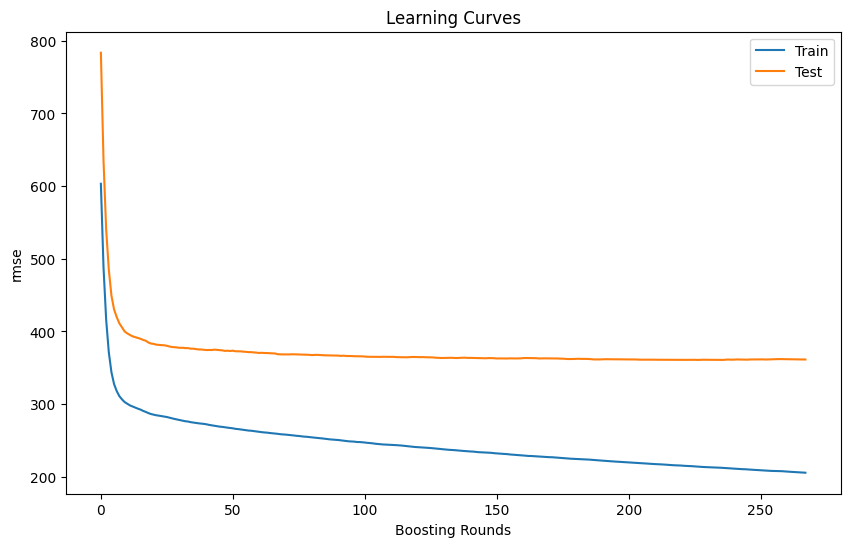

In [254]:
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg.evals_result()
train_errors = results['validation_0'][eval_metric]
test_errors = results['validation_1'][eval_metric]

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel(eval_metric)
plt.legend()
plt.title('Learning Curves')
plt.show()

min_error_a = min(test_errors)

In [255]:
min_error_a

360.69449047301714

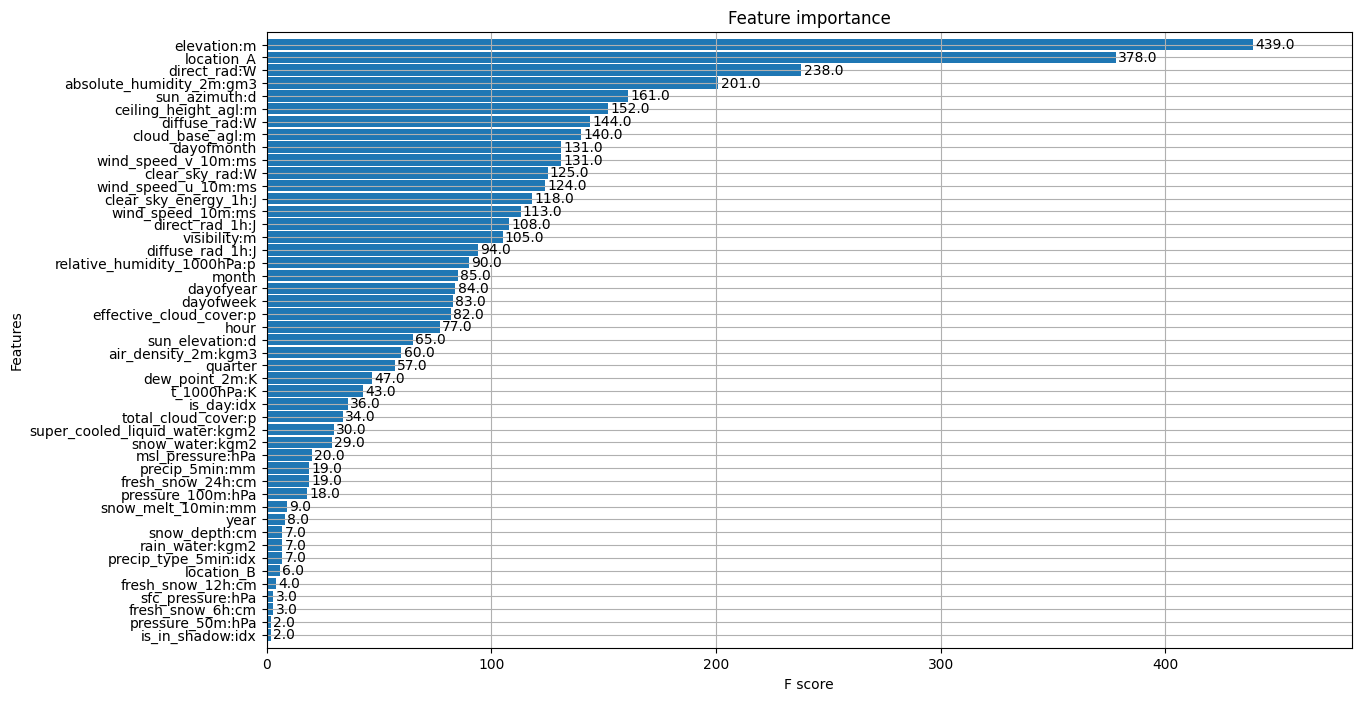

In [256]:
plot_importance(reg, height=.9)
plt.gcf().set_size_inches(14, 8)
# plot_importance(reg_b, height=0.9)
# plt.gcf().set_size_inches(14, 8)
# plot_importance(reg_c, height=0.9)
# plt.gcf().set_size_inches(14, 8)

In [257]:
pv_test_to_concate= { 'A': pv_test_a, 'B': pv_test_b, 'C': pv_test_c }
pv_test = concat_df_from_differents_locations(pv_test_to_concate)

pv_train_to_concate = { 'A': pv_train_a, 'B': pv_train_b, 'C': pv_train_c }
pv_train = concat_df_from_differents_locations(pv_train_to_concate)

In [258]:
# mask_a = ((pv_test['date_forecast'] > split_date_a) & (pv_test['date_forecast'] <= split_date2_a)) & (pv_test['location_A'] == 1)
# mask_b = ((pv_test['date_forecast'] > split_date_b) & (pv_test['date_forecast'] <= split_date2_b)) & (pv_test['location_B'] == 1)
# mask_c = ((pv_test['date_forecast'] > split_date_c) & (pv_test['date_forecast'] <= split_date2_c)) & (pv_test['location_C'] == 1)
# mask = (mask_a | mask_b | mask_c)
# pv_test['pv_measurement_prediction'] = pd.NA
pv_test['pv_measurement_prediction'] = reg.predict(X_test_norm)
# pv_test['pv_measurement_prediction'] = reg.predict(X_test_norm)
pv_all = pd.concat([pv_test, pv_train], sort=False)
pv_all = pv_all.sort_values(by=['location_C','location_B','location_A', 'date_forecast'])

In [259]:
pv_test[pv_test['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.

/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_50364/396292492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_test[pv_test['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.


In [260]:
mae = np.mean(np.abs(pv_all['pv_measurement'] - pv_all['pv_measurement_prediction']))
# print("MAE a:", mae_a, "MAE b:", mae_b, "MAE c:", mae_c)
print("MAE on test set:", mae)

MAE on test set: 156.63250514835872


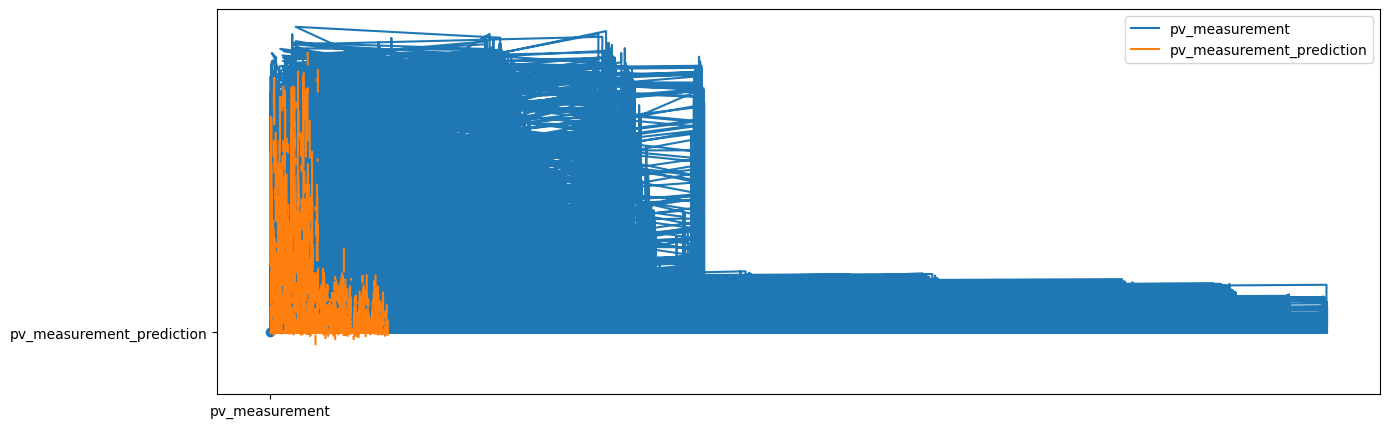

In [261]:
graph = pv_all[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')
# graph = pv_all_b[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')
# graph = pv_all_c[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')

In [262]:
# np_pv_c = np.array(pv_all_c['pv_measurement'])
# plt.plot(np_pv_c)

# Export sur Kaggle

In [263]:
test = pd.read_csv(path+"test.csv")
test_copy = test.copy()
test.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
test["date_forecast"] = pd.to_datetime(test["date_forecast"]) #mettre le bon type

In [264]:
# Lecture des données météo associée :
merged_df_pre_a = pd.merge(X_test_estimated_a, test, on='date_forecast', how='inner')
merged_df_a = merged_df_pre_a[merged_df_pre_a["location"]=="A"]
merged_df_pre_b = pd.merge(X_test_estimated_b, test, on='date_forecast', how='inner')
merged_df_b = merged_df_pre_b[merged_df_pre_b["location"]=="B"]
merged_df_pre_c = pd.merge(X_test_estimated_c, test, on='date_forecast', how='inner')
merged_df_c = merged_df_pre_c[merged_df_pre_c["location"]=="C"]

In [265]:
def preprocessing_test(df,scaler):
  X_test = df.drop(["id","location","prediction"],axis=1)
  X_test = create_features(X_test, None)
  #X_test[('date_forecast')] = X_test[('date_forecast')].values.astype("float64")
  X_test = gestion_nan(X_test)
  X_test = sklearn_z_score_normalize_dataframe(X_test,return_scaler=False,scaler=scaler)
  return X_test

In [266]:
X_test_a_test = preprocessing_test(merged_df_a,scaler_a)
X_test_b_test = preprocessing_test(merged_df_b,scaler_b)
X_test_c_test = preprocessing_test(merged_df_c,scaler_c)

In [267]:
X_pred_to_concat = { 'A': X_test_a_test, 'B': X_test_b_test, 'C': X_test_c_test }
X_pred = concat_df_from_differents_locations(X_pred_to_concat)

In [268]:
results = reg.predict(X_pred)

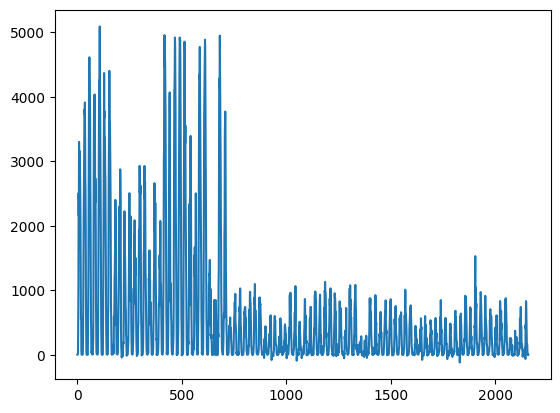

In [269]:
plt.plot(results)

In [270]:
nom_fichier = 'XGBoost_Valentin_V2'
repertoire = path
# result = np.concatenate((np.concatenate((result_A,result_B)), result_C))
test_copy['prediction'] = results
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

Prochaines amélioration

- mettre un minimum *Done*
- suppression des zones continues en B et C *To DO*
- prise en compte de la date (jour/mois/heure) *Done* peut être ajusté ?
- prendre le meilleur model : celui avec le meilleur score sur le deuxième testset (A : 2,8% B : 5,5%  C: 11,5%) (score eval prévu : 166) --> déjà pris en copmte dans la fonction ...


Perf V1:

A : Test 2 : 446 / 459

B : Test 2 : 101 / 107

C : Test 2 : 68 / 78

Perf V2:

A : Test 1 : 243 | Test 2 : 438 / 455

B : Test 1 : 35 | Test 2 : 106 / 110

C : Test 1 : 26 | Test 2 : 65 / 71

# Post traitement

Ici, on va faire en sorte de n'avoir que des valeurs positives (cela ne représente qu'une légère amélioration

In [271]:
# result = np.concatenate((np.concatenate((result_A,result_B)), result_C))

In [272]:
negative_values = results[results < 0]
sum_of_negatives = np.sum(negative_values**2)/len(results)
np.sqrt(sum_of_negatives)

6.082728637183407

In [273]:
negative_mask = results < 10
results[negative_mask] = 0

In [274]:
nom_fichier = f'XGBoost_grouped_loc_n_estimators_{n_estimators}_delta_{delta_title}_min_{scaler_name}_max_depth_{max_depth}_mae_{int(mae)}_{eval_metric}_{int(min_error_a)}_rd_sets_{random_state}'
repertoire = submission_path
test_copy['prediction'] = results
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

In [275]:
# result2 = np.concatenate((np.concatenate((result_A,result_B)), result_C))

In [276]:
# negative_mask2 = result2 < 10
# result2[negative_mask2] = 0